<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (GCC1932) - Trabalho 3</center></h1>

- Nome completo: Bianca Gallicchio Tavares
- [Link para vídeo](https://youtu.be/pR8AvE2IriM)

## Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

# Configurações
np.random.seed(42)
plt.style.use('ggplot')

## Carregando o dataset

In [9]:
def load_and_preprocess(data_path, feature_dict_path, window_size=4):
    # Carrega os dados
    with open(data_path, 'rb') as f:
        X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)
    
    # Carrega o dicionário de features
    feature_dict = pd.read_csv(feature_dict_path)
    
    # Define features base (apenas climáticas brutas)
    base_features = [
        'TEM_AVG', 'TEM_MIN', 'TEM_MAX', 'RAIN', 
        'RH_AVG', 'RH_MIN', 'RH_MAX', 'IDEAL_TEMP',
        'EXTREME_TEMP', 'SIGNIFICANT_RAIN', 'EXTREME_RAIN',
        'TEMP_RANGE', 'WEEK_OF_YEAR'
    ]
    
    # Obtém índices das features base
    base_idx = [feature_dict[feature_dict['Feature'] == f].index[0] for f in base_features]
    
    # Normalização (apenas nas features base)
    scaler = MinMaxScaler()
    X_train_base = X_train[:, base_idx]
    scaler.fit(X_train_base)
    
    # Função para criar sequências temporais
    def create_sequences(X, y):
        X_seq, y_seq = [], []
        for i in range(window_size, len(X)):
            X_seq.append(scaler.transform(X[i-window_size:i, base_idx]))
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)
    
    # Cria sequências normalizadas
    X_train_seq, y_train_seq = create_sequences(X_train, y_train)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test)
    
    return (X_train_seq, y_train_seq, 
            X_val_seq, y_val_seq, 
            X_test_seq, y_test_seq,
            feature_dict, base_features)

# Uso:
data_path = 'DATASETS/RJ_WEEKLY/dataset.pickle'
feature_dict_path = 'DATASETS/RJ_WEEKLY/feature_dictionary.csv'
window_size = 4  # semanas históricas

(X_train_seq, y_train_seq, 
 X_val_seq, y_val_seq, 
 X_test_seq, y_test_seq, 
 feature_dict, base_features) = load_and_preprocess(data_path, feature_dict_path, window_size)

In [ ]:
# Exemplo para temperatura média
plt.figure(figsize=(14, 6))
plt.plot(df_train_climate['TEM_AVG'].values[:200], label='Temperatura Média')
plt.plot(df_train_climate['Casos'].values[:200]/df_train_climate['Casos'].max(), label='Casos (normalizado)')
plt.legend()
plt.title('Relação Temporal entre Temperatura e Casos de Dengue')
plt.show()

Modelo LSTM

In [3]:
def build_and_train_lstm(X_train, y_train, X_val, y_val, n_features):
    model = Sequential([
        LSTM(64, input_shape=(window_size, n_features), return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    callbacks = [
        EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Treinamento
n_features = len(base_features)
lstm_model, lstm_history = build_and_train_lstm(
    X_train_seq, y_train_seq, 
    X_val_seq, y_val_seq, 
    n_features
)

Epoch 1/100


c:\Users\User\anaconda3\envs\dengue_dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3674/3674 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 13.9873 - mae: 0.3743 - val_loss: 2.3876 - val_mae: 0.3261 - learning_rate: 0.0010
Epoch 2/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 12.7226 - mae: 0.3791 - val_loss: 2.3845 - val_mae: 0.3150 - learning_rate: 0.0010
Epoch 3/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 15.4379 - mae: 0.3917 - val_loss: 2.3828 - val_mae: 0.3236 - learning_rate: 0.0010
Epoch 4/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 13.2446 - mae: 0.3803 - val_loss: 2.3962 - val_mae: 0.2787 - learning_rate: 0.0010
Epoch 5/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 15.6158 - mae: 0.4002 - val_loss: 2.4318 - val_mae: 0.3123 - learning_rate: 0.0010
Epoch 6/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 15.9392 - mae: 0.4057 - val_loss: 2.3845 - val_mae: 0.2986 - learning_rate: 0.0010
Epoch 7/100
3674/3674 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 15.0844 - mae: 0.3843 - val_loss: 2.4462 - val_mae: 0.3455 - learn

## Avaliação e Visualização

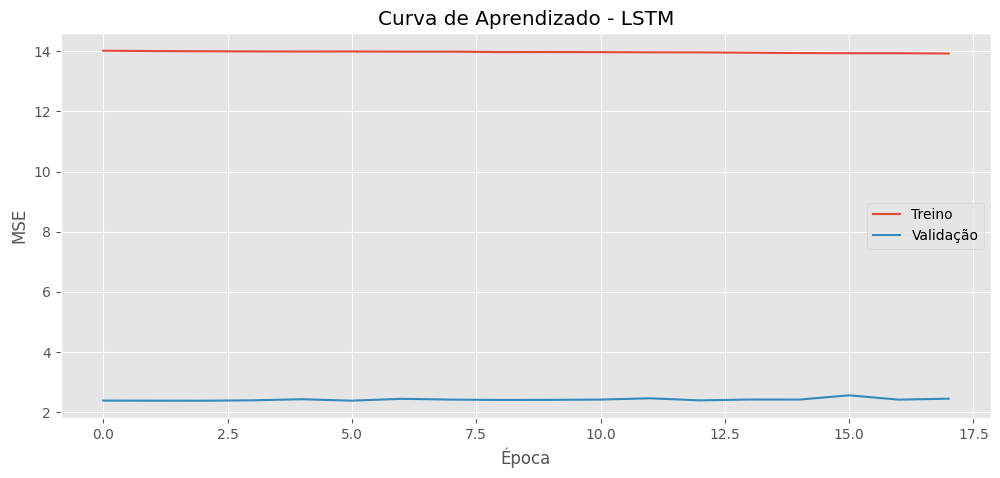

2853/2853 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.9296 - mae: 0.4271

Test MSE: 5.4920, Test MAE: 0.4975
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


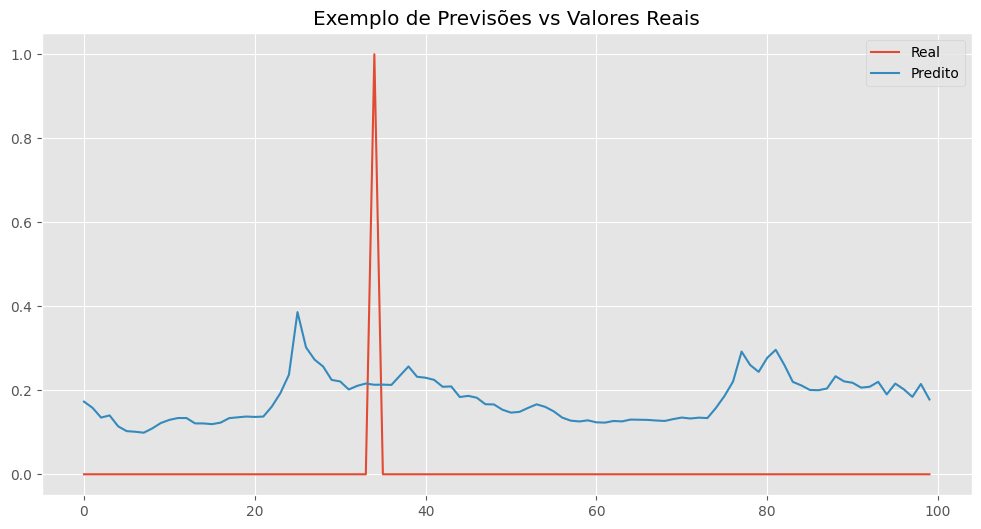

In [4]:
# Curva de aprendizado
plt.figure(figsize=(12, 5))
plt.plot(lstm_history.history['loss'], label='Treino')
plt.plot(lstm_history.history['val_loss'], label='Validação')
plt.title('Curva de Aprendizado - LSTM')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()
plt.show()

# Avaliação no teste
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq)
print(f"\nTest MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Previsões de exemplo
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:100], label='Real')
plt.plot(lstm_model.predict(X_test_seq[:100]), label='Predito')
plt.title('Exemplo de Previsões vs Valores Reais')
plt.legend()
plt.show()

In [5]:
print(f"Shapes finais:\n  X_train: {X_train_seq.shape}\n  y_train: {y_train_seq.shape}")

Shapes finais:
  X_train: (235114, 4, 13)
  y_train: (235114,)


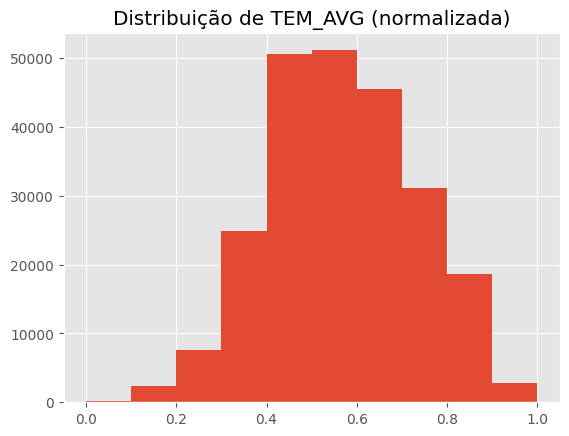

In [6]:
plt.hist(X_train_seq[:, 0, 0])  # Primeira feature no primeiro timestep
plt.title("Distribuição de TEM_AVG (normalizada)")
plt.show()

In [7]:
print("Previsões iniciais:", lstm_model.predict(X_train_seq[:3]).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Previsões iniciais: [0.13507628 0.14653906 0.131587  ]
